In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import skimage as ski
import sklearn as skl
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
from original_helpers import *

In [2]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(20, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

n = 10 # Only use 10 images for training

Loading 20 images
satImage_001.png
Loading 20 images
satImage_001.png


Image size = 400,400


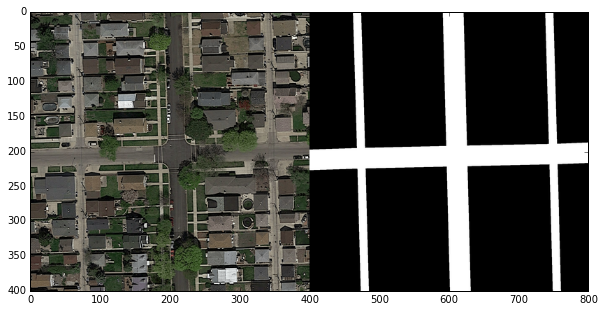

In [3]:
print('Image size = ' + str(imgs[0].shape[0]) + ',' + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

[0, 400, 400, 0]

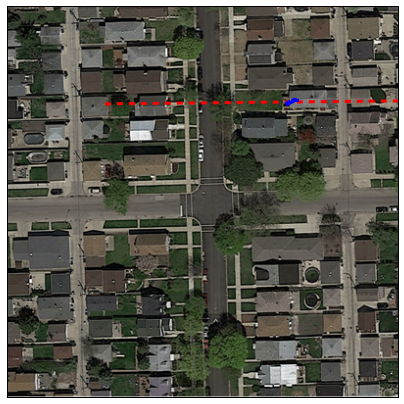

In [4]:
from skimage.segmentation import active_contour
s = np.linspace(0, imgs[0].shape[0],10)
init = np.array([s, -s/100]).T +100
#snake = active_contour(imgs[0], init, w_edge=0, w_line=1)

snake = active_contour(imgs[0], init)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
plt.gray()
ax.imshow(imgs[0])
ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, imgs[0].shape[1], imgs[0].shape[0], 0])

In [5]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = extract_patches(imgs, patch_size)
gt_patches = extract_patches(gt_imgs, patch_size)

In [6]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

X = np.asarray([ extract_features(img_patches[i]) for i in range(len(img_patches))])
Y = np.asarray([value_to_class(np.mean(gt_patches[i]), foreground_threshold) for i in range(len(gt_patches))])

In [7]:
# Print feature statistics

print('Computed ' + str(X.shape[0]) + ' features')
print('Feature dimension = ' + str(X.shape[1]))
print('Number of classes = ' + str(np.max(Y)))

Y0 = [i for i, j in enumerate(Y) if j == 0]
Y1 = [i for i, j in enumerate(Y) if j == 1]
print('Class 0: ' + str(len(Y0)) + ' samples')
print('Class 1: ' + str(len(Y1)) + ' samples')

Computed 12500 features
Feature dimension = 6
Number of classes = 1
Class 0: 9450 samples
Class 1: 3050 samples


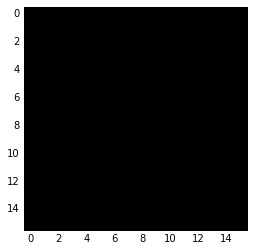

In [8]:
# Display a patch that belongs to the foreground class
plt.imshow(gt_patches[Y1[3]], cmap='Greys_r')

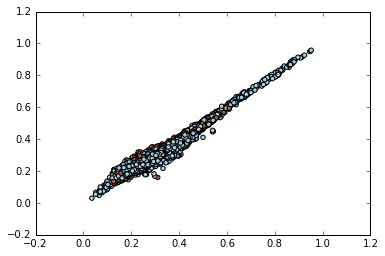

In [9]:
# Plot 2d features using groundtruth to color the datapoints
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)

In [10]:
# train a logistic regression classifier

from sklearn import linear_model

# we create an instance of the classifier and fit the data
logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
logreg.fit(X, Y)

LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [11]:
# Predict on the training set
Z = logreg.predict(X)

TPR = compute_true_positive_rate(Y, Z)

print('True positive rate = ' + str(TPR))

True positive rate = 0.15304


In [19]:
from sklearn.metrics import confusion_matrix

confusion_matrix(Y,Z)

array([[6017, 3433],
       [1231, 1819]])

In [12]:
from sklearn.metrics import f1_score

f1_score(Y, Z, average='binary')

0.44068187053674263

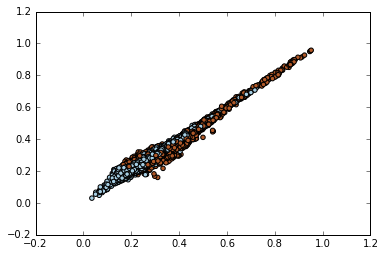

In [13]:
# Plot features using predictions to color datapoints
plt.scatter(X[:, 0], X[:, 1], c=Z, edgecolors='k', cmap=plt.cm.Paired)

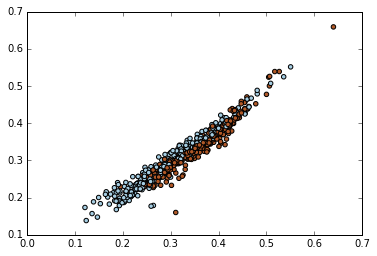

In [14]:
# Run prediction on the img_idx-th image
img_idx = 12

Xi = extract_img_features(image_dir + files[img_idx], patch_size)
Zi = logreg.predict(Xi)
plt.scatter(Xi[:, 0], Xi[:, 1], c=Zi, edgecolors='k', cmap=plt.cm.Paired)

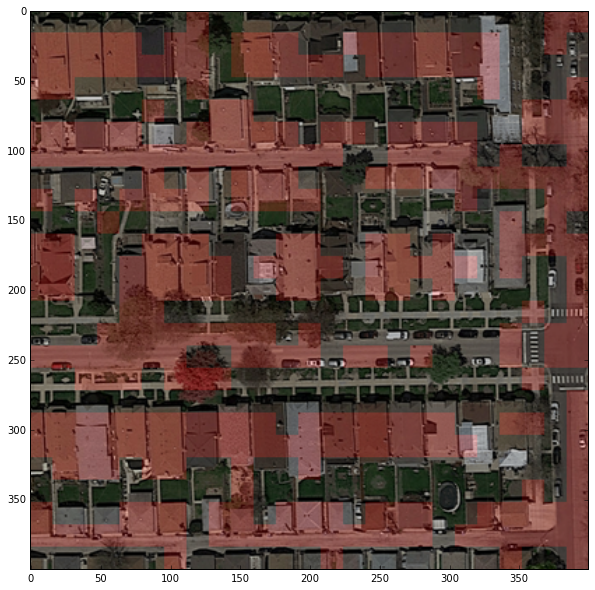

In [15]:
display_prediction(imgs[img_idx], patch_size, Zi)

Let's follow scikit-learn algorithm cheat-sheet:

![ML-cheatsheet](http://scikit-learn.org/stable/_static/ml_map.png)

START -> >50 samples (YES) -> predicting a category (YES) -> labled data (YES) -> <100k samples (YES) -> 
### Linear SVC

In [16]:
# train a logistic regression classifier

from sklearn import svm

# we create an instance of the classifier and fit the data
linearSVC = svm.LinearSVC(C=6.0, class_weight={1: 3})# class_weight="balanced"), class_weight="balanced")
linearSVC.fit(X, Y)

LinearSVC(C=6.0, class_weight={1: 3}, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [17]:
# Predict on the training set
Z = linearSVC.predict(X)

TPR = compute_true_positive_rate(Y, Z)

print('True positive rate = ' + str(TPR))

True positive rate = 0.14552


In [21]:
confusion_matrix(Y, Z)

array([[6017, 3433],
       [1231, 1819]])

In [22]:
f1_score(Y, Z, average='binary')

0.43820766080462537

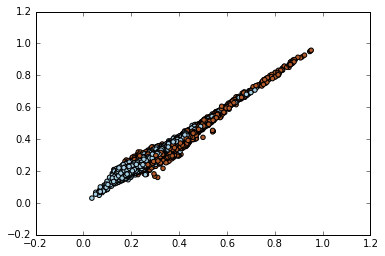

In [23]:
plt.scatter(X[:, 0], X[:, 1], c=Z, edgecolors='k', cmap=plt.cm.Paired)

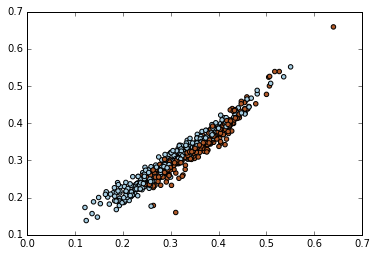

In [25]:
# Run prediction on the img_idx-th image
img_idx = 12

Xi = extract_img_features(image_dir + files[img_idx], patch_size)
Zi = linearSVC.predict(Xi)
plt.scatter(Xi[:, 0], Xi[:, 1], c=Zi, edgecolors='k', cmap=plt.cm.Paired)

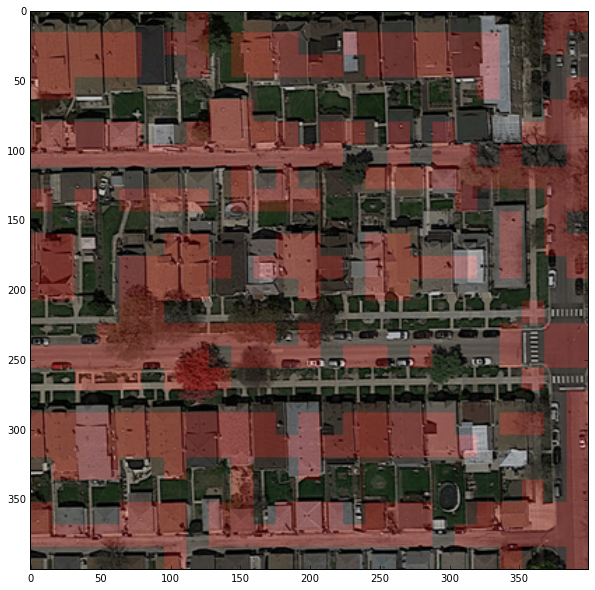

In [26]:
# Display prediction as an image
display_prediction(imgs[img_idx], patch_size, Zi)

START -> >50 samples (YES) -> predicting a category (YES) -> labled data (YES) -> <100k samples (YES) -> Linear SVC (Not Working) -> Text data (NO) -> 
### KNeighbors Classifier 

In [27]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(X, Y) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [28]:
# Predict on the training set
Z = neigh.predict(X)

TPR = compute_true_positive_rate(Y, Z)

print('True positive rate = ' + str(TPR))

True positive rate = 0.12504


In [29]:
confusion_matrix(Y, Z)

array([[9450,    0],
       [1487, 1563]])

In [30]:
f1_score(Y, Z, average='binary')

0.6776501192282679

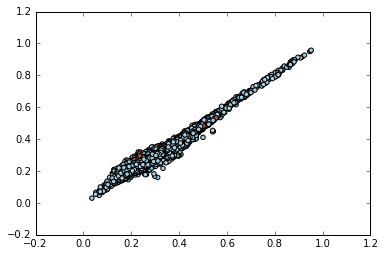

In [31]:
plt.scatter(X[:, 0], X[:, 1], c=Z, edgecolors='k', cmap=plt.cm.Paired)

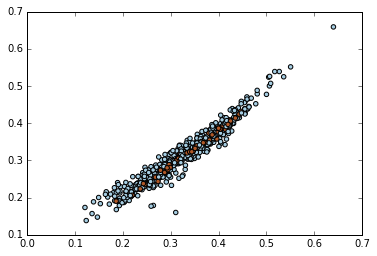

In [32]:
# Run prediction on the img_idx-th image
img_idx = 12

Xi = extract_img_features(image_dir + files[img_idx], patch_size)
Zi = neigh.predict(Xi)
plt.scatter(Xi[:, 0], Xi[:, 1], c=Zi, edgecolors='k', cmap=plt.cm.Paired)

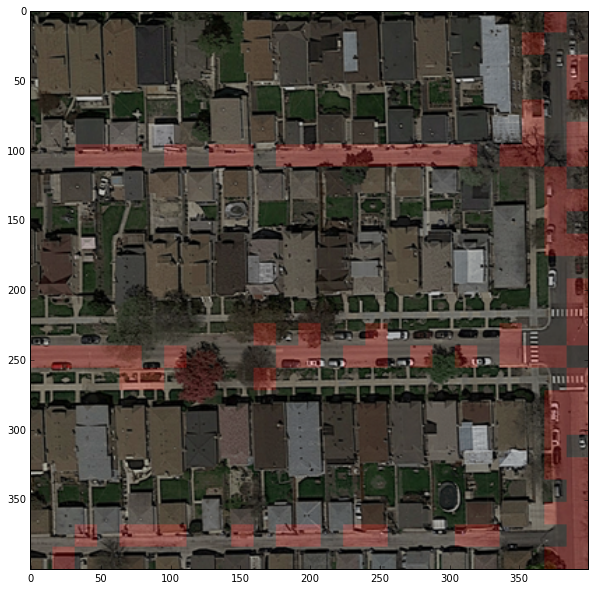

In [33]:
# Display prediction as an image
display_prediction(imgs[img_idx], patch_size, Zi)

### SVC

In [84]:
from sklearn.svm import SVC
svc = SVC(C=1e6, class_weight={1: 5})
svc.fit(X, Y) 

SVC(C=1000000.0, cache_size=200, class_weight={1: 5}, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [85]:
# Predict on the training set
Z = svc.predict(X)

TPR = compute_true_positive_rate(Y, Z)

print('True positive rate = ' + str(TPR))

True positive rate = 0.22888


In [86]:
confusion_matrix(Y, Z)

array([[4328, 5122],
       [ 189, 2861]])

In [87]:
f1_score(Y, Z, average='binary')

0.51862594036073595

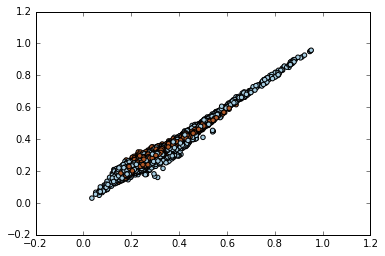

In [88]:
plt.scatter(X[:, 0], X[:, 1], c=Z, edgecolors='k', cmap=plt.cm.Paired)

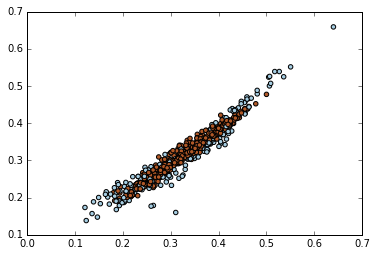

In [89]:
# Run prediction on the img_idx-th image
img_idx = 12

Xi = extract_img_features(image_dir + files[img_idx], patch_size)
Zi = svc.predict(Xi)
plt.scatter(Xi[:, 0], Xi[:, 1], c=Zi, edgecolors='k', cmap=plt.cm.Paired)

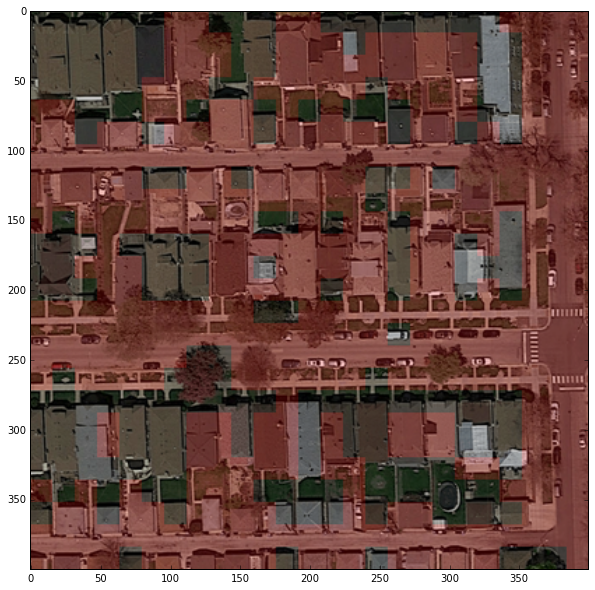

In [90]:
# Display prediction as an image
display_prediction(imgs[img_idx], patch_size, Zi)

### Ensamble methods

In [106]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=5)
forest = forest.fit(X, Y)

In [107]:
# Predict on the training set
Z = forest.predict(X)

TPR = compute_true_positive_rate(Y, Z)

print('True positive rate = ' + str(TPR))

True positive rate = 0.2228


In [108]:
confusion_matrix(Y, Z)

array([[9358,   92],
       [ 265, 2785]])

In [109]:
f1_score(Y, Z, average='binary') #Yeah forest overfitts easily

0.93976716720094478

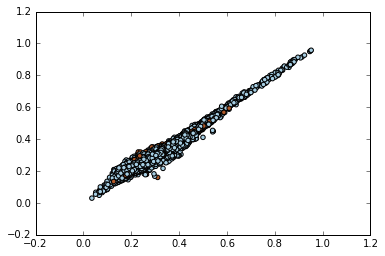

In [110]:
plt.scatter(X[:, 0], X[:, 1], c=Z, edgecolors='k', cmap=plt.cm.Paired)

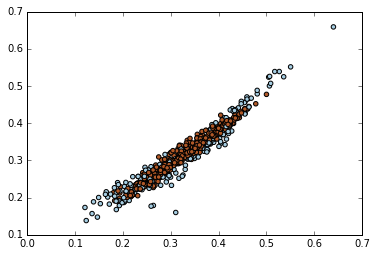

In [111]:
# Run prediction on the img_idx-th image
img_idx = 12

Xi = extract_img_features(image_dir + files[img_idx], patch_size)
Zi = svc.predict(Xi)
plt.scatter(Xi[:, 0], Xi[:, 1], c=Zi, edgecolors='k', cmap=plt.cm.Paired)

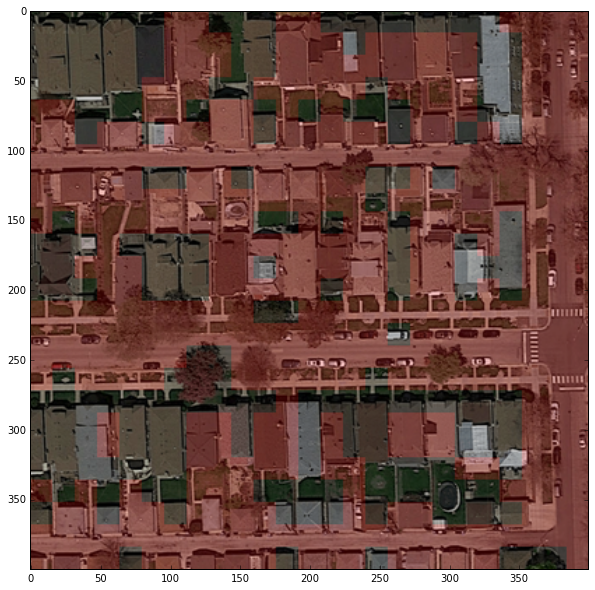

In [112]:
# Display prediction as an image
display_prediction(imgs[img_idx], patch_size, Zi)